# Support Vector Machine
In this notebook, we fit a SVM to the regression problem of predicting mean activity based on non-wearable features taken from the UK biobank. 

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

In [2]:
from accel.read_data import prep_data
from accel.constants import DATA_DIR, DEMO, PHYSICAL

## Data prep

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test, means_modes = prep_data(DATA_DIR / "shared/reduced-cohort.csv", 
                                                                        sets=(DEMO, PHYSICAL),
                                                                        one_hot = True)

In [4]:
print(X_train.shape)
X_train.head()

(69567, 38)


,MET minutes per week for walking | Instance 0,Frequency of stair climbing in last 4 weeks | Instance 0,Age at recruitment,Summed days activity | Instance 0,MET minutes per week for moderate activity | Instance 0,Duration of walks | Instance 0,MET minutes per week for vigorous activity | Instance 0,Body mass index (BMI) | Instance 0,IPAQ activity group | Instance 0_high,IPAQ activity group | Instance 0_low,...,Ethnic background | Instance 0_Indian,Ethnic background | Instance 0_Irish,Ethnic background | Instance 0_Mixed,Ethnic background | Instance 0_Other ethnic group,Ethnic background | Instance 0_Pakistani,Ethnic background | Instance 0_Prefer not to answer,Ethnic background | Instance 0_White,Ethnic background | Instance 0_White and Asian,Ethnic background | Instance 0_White and Black African,Ethnic background | Instance 0_White and Black Caribbean
9661,891.000000,15.0,51,10.00000,40.000000,45.000000,720.000000,25.0693,1,0,...,0,1,0,0,0,0,0,0,0,0
14337,982.114756,20.0,57,10.65833,879.769696,40.000000,664.653821,22.8466,0,0,...,0,0,0,0,0,0,0,0,0,0
16362,982.114756,10.0,66,13.00000,879.769696,120.000000,664.653821,23.3810,0,0,...,0,1,0,0,0,0,0,0,0,0
45710,982.114756,10.0,62,10.65833,879.769696,56.166823,664.653821,33.6458,0,0,...,0,0,0,0,0,0,0,0,0,0
30123,462.000000,0.0,65,17.00000,1680.000000,20.000000,240.000000,25.8806,1,0,...,0,0,0,0,0,0,0,0,0,0


# Support vector machine

In [5]:
from time import time
from sklearn import svm
from accel.training import model_tune, score

## Timing
Timing how long it takes to fit an SVM to different sizes of data. Keep in mind, there are 69567 training observations.

In [6]:
Ns = np.arange(100,10001,1000)
Ns

array([ 100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100])

In [7]:
reps = 5
times = np.zeros((reps,len(Ns)))

for r in range(reps):
    print("Rep",r, "Size:", end="")
    for i in range(len(Ns)):
        print(Ns[i],end=", ")
        N = Ns[i]
        clf = svm.SVR() # default SVR with an RBF kernel
        start = time()
        clf.fit(X_train[:N], y_train[:N ]) #train model and time
        times[r,i] = time() - start
    print()

Rep 0 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 1 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 2 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 3 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 4 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 


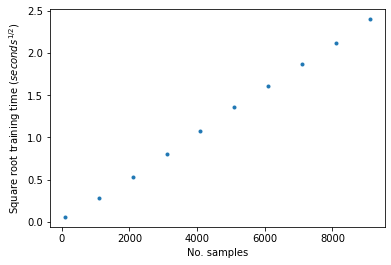

In [8]:
plt.plot(Ns, np.sqrt(np.mean(times,axis=0)), ".")
plt.xlabel("No. samples")
plt.ylabel("Square root training time ($seconds^{1/2}$)")
plt.show()

In [9]:
root_mean_times = np.sqrt(np.mean(times,axis=0))
m = root_mean_times[-1] / Ns[-1]
m

0.0002638164741509196

In [10]:
(m * 9100)

2.4007299147733683

As we can see, the training algorithm is quadratic in the number of samples. We can estimate the time it would take on the full data set as follows:

$N = \text{number of samples}$

$\text{Mean time}^{1/2} = 265\cdot 10^{-4} \times N$

$\text{Mean time} = ( 265\cdot 10^{-4} \times N ) ^2$

In [12]:
N_train = X_train.shape[0]
pred_secs = (m * N_train)**2 #answer in seconds
print("Predicted training time in minutes", pred_secs / 60) # answer in minutes

Predicted training time in minutes 5.613828277526193


In [13]:
pred_secs / (4 * 60)

1.4034570693815482

In [16]:
# fitting the dataset, which might take 5 minutes
clf = svm.SVR()
start = time()
clf.fit(X_train[:N_train], y_train[:N_train]) #train model and tim
time() - start

400.76198744773865

In [18]:
400/60 # so actually took a bit longer

6.666666666666667

How good is the out the box model?

In [17]:
from accel.training import score

In [22]:
y_pred = clf.predict(X_val[X_train.columns])

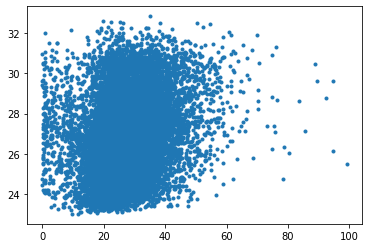

In [24]:
plt.plot(y_val,y_pred, ".")

In [25]:
score(y_val, y_pred)

MSE is:  81.03292741212928
R2 is:  0.04825443204114721
Explained variance is: 0.051946629840488256


# Hyper-parameter tuning

In [9]:
# define lists of params interested in

kernel = ['poly', 'rbf', 'sigmoid'] #type of kernel used
C = np.geomspace(1e-3,1,10) # Small C -> big regularisation.

params = {
    "kernel" : kernel,
    "C"      : C
}

In [11]:
# TO DO
clf = model_tune(svm.SVR(), params, X_train, y_train, 3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 